In [36]:
tffile = "../external/human_TF_annotation_gencode_v26.txt"
random_snp_dir = "/usr/users/sbanerj/gtex_v8/genotype/all_samples/random_sampling"
chrmlist = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
cis_window = 0.1

resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8_tejaas_permnull_sb0.1_knn"
tissue_file = "../tissue_table.txt"
rrfile = "trans_eqtls.txt"
json_file = "../external/gtex_metadata.json"

In [37]:
import numpy as np
import collections
import os
import math
import json

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import utils
from utils import mpl_stylesheet
from utils import read_tejaas_results
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

In [38]:
GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

tflist = list()
with open(tffile, 'r') as instream:
    next(instream)
    for line in instream:
        linesplit = line.strip().split()
        ensembl = linesplit[0]
        chrom = int(linesplit[1])
        start = int(linesplit[2])
        end = int(linesplit[3])
        name = linesplit[4]
        tflist.append(GeneInfo(name = name, ensembl_id = ensembl, chrom = chrom, start = start, end = end))

In [39]:
def find_minimum_distance(spos, starts, ends):
    diffs = zip([spos - x for x in starts], [spos - x for x in ends])
    dists = np.array([math.copysign(min(abs(a), abs(b)), a) if a * b > 0 else 0 for a, b in diffs])
    return dists[np.argmin(np.abs(dists))]

In [48]:
def get_random_mindist(chrmlist, outdir, tflist):
    mindist_rand = list()
    for chrm in chrmlist:
        filename = os.path.join(outdir, f'chr{chrm}.txt')
        tfstarts = [x.start for x in tflist if x.chrom == chrm]
        tfends = [x.end for x in tflist if x.chrom == chrm]

        with open(filename, 'r') as infile:
            for line in infile:
                line = line.strip()
                spos = int(line.split()[0].strip())
                xmin = find_minimum_distance(spos, tfstarts, tfends)
                mindist_rand.append(xmin / 1e6)
    mindist_rand = np.array(mindist_rand)
    return mindist_rand

In [52]:
Niter = 10
tf_frac_rand = 0
for i in range(Niter):
    iterdir = os.path.join(random_snp_dir, f'random_50000_{i+1 :02d}')
    mindist_rand = get_random_mindist(chrmlist, iterdir, tflist)
    this_tf_frac = np.sum(np.abs(mindist_rand) <= cis_window) / mindist_rand.shape[0]
    print(f'Iteration {i+1}. Fraction of SNPs with cis TFs = {this_tf_frac}')
    tf_frac_rand += this_tf_frac
tf_frac_rand /= Niter

print(f'Fraction of cis TFs for randomly selected SNPs: {tf_frac_rand :7.4f}')

Iteration 1. Fraction of SNPs with cis TFs = 0.114
Iteration 2. Fraction of SNPs with cis TFs = 0.13333466661333546
Iteration 3. Fraction of SNPs with cis TFs = 0.14475420983160672
Iteration 4. Fraction of SNPs with cis TFs = 0.11989760204795905
Iteration 5. Fraction of SNPs with cis TFs = 0.11804
Iteration 6. Fraction of SNPs with cis TFs = 0.13416
Iteration 7. Fraction of SNPs with cis TFs = 0.13638545541821673
Iteration 8. Fraction of SNPs with cis TFs = 0.1343946242150314
Iteration 9. Fraction of SNPs with cis TFs = 0.11730234604692094
Iteration 10. Fraction of SNPs with cis TFs = 0.10687358758474491
Fraction of cis TFs for randomly selected SNPs:  0.1259


In [55]:
Niter = 1000

enrichment_rand = list()
for i in range(Niter):
    if (i + 1) % 10 == 0:
        print(f'Iteration {i + 1}')
    iterdir = os.path.join(random_snp_dir, f'random_1000_{i+1 :04d}')
    mindist_rand = get_random_mindist(chrmlist, iterdir, tflist)
    this_tf_frac = np.sum(np.abs(mindist_rand) <= cis_window) / mindist_rand.shape[0]
    this_tf_enrichment = this_tf_frac / tf_frac_rand
    enrichment_rand.append(this_tf_enrichment)
    
enrichment_rand = np.array(enrichment_rand)

Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Iteration 720
I

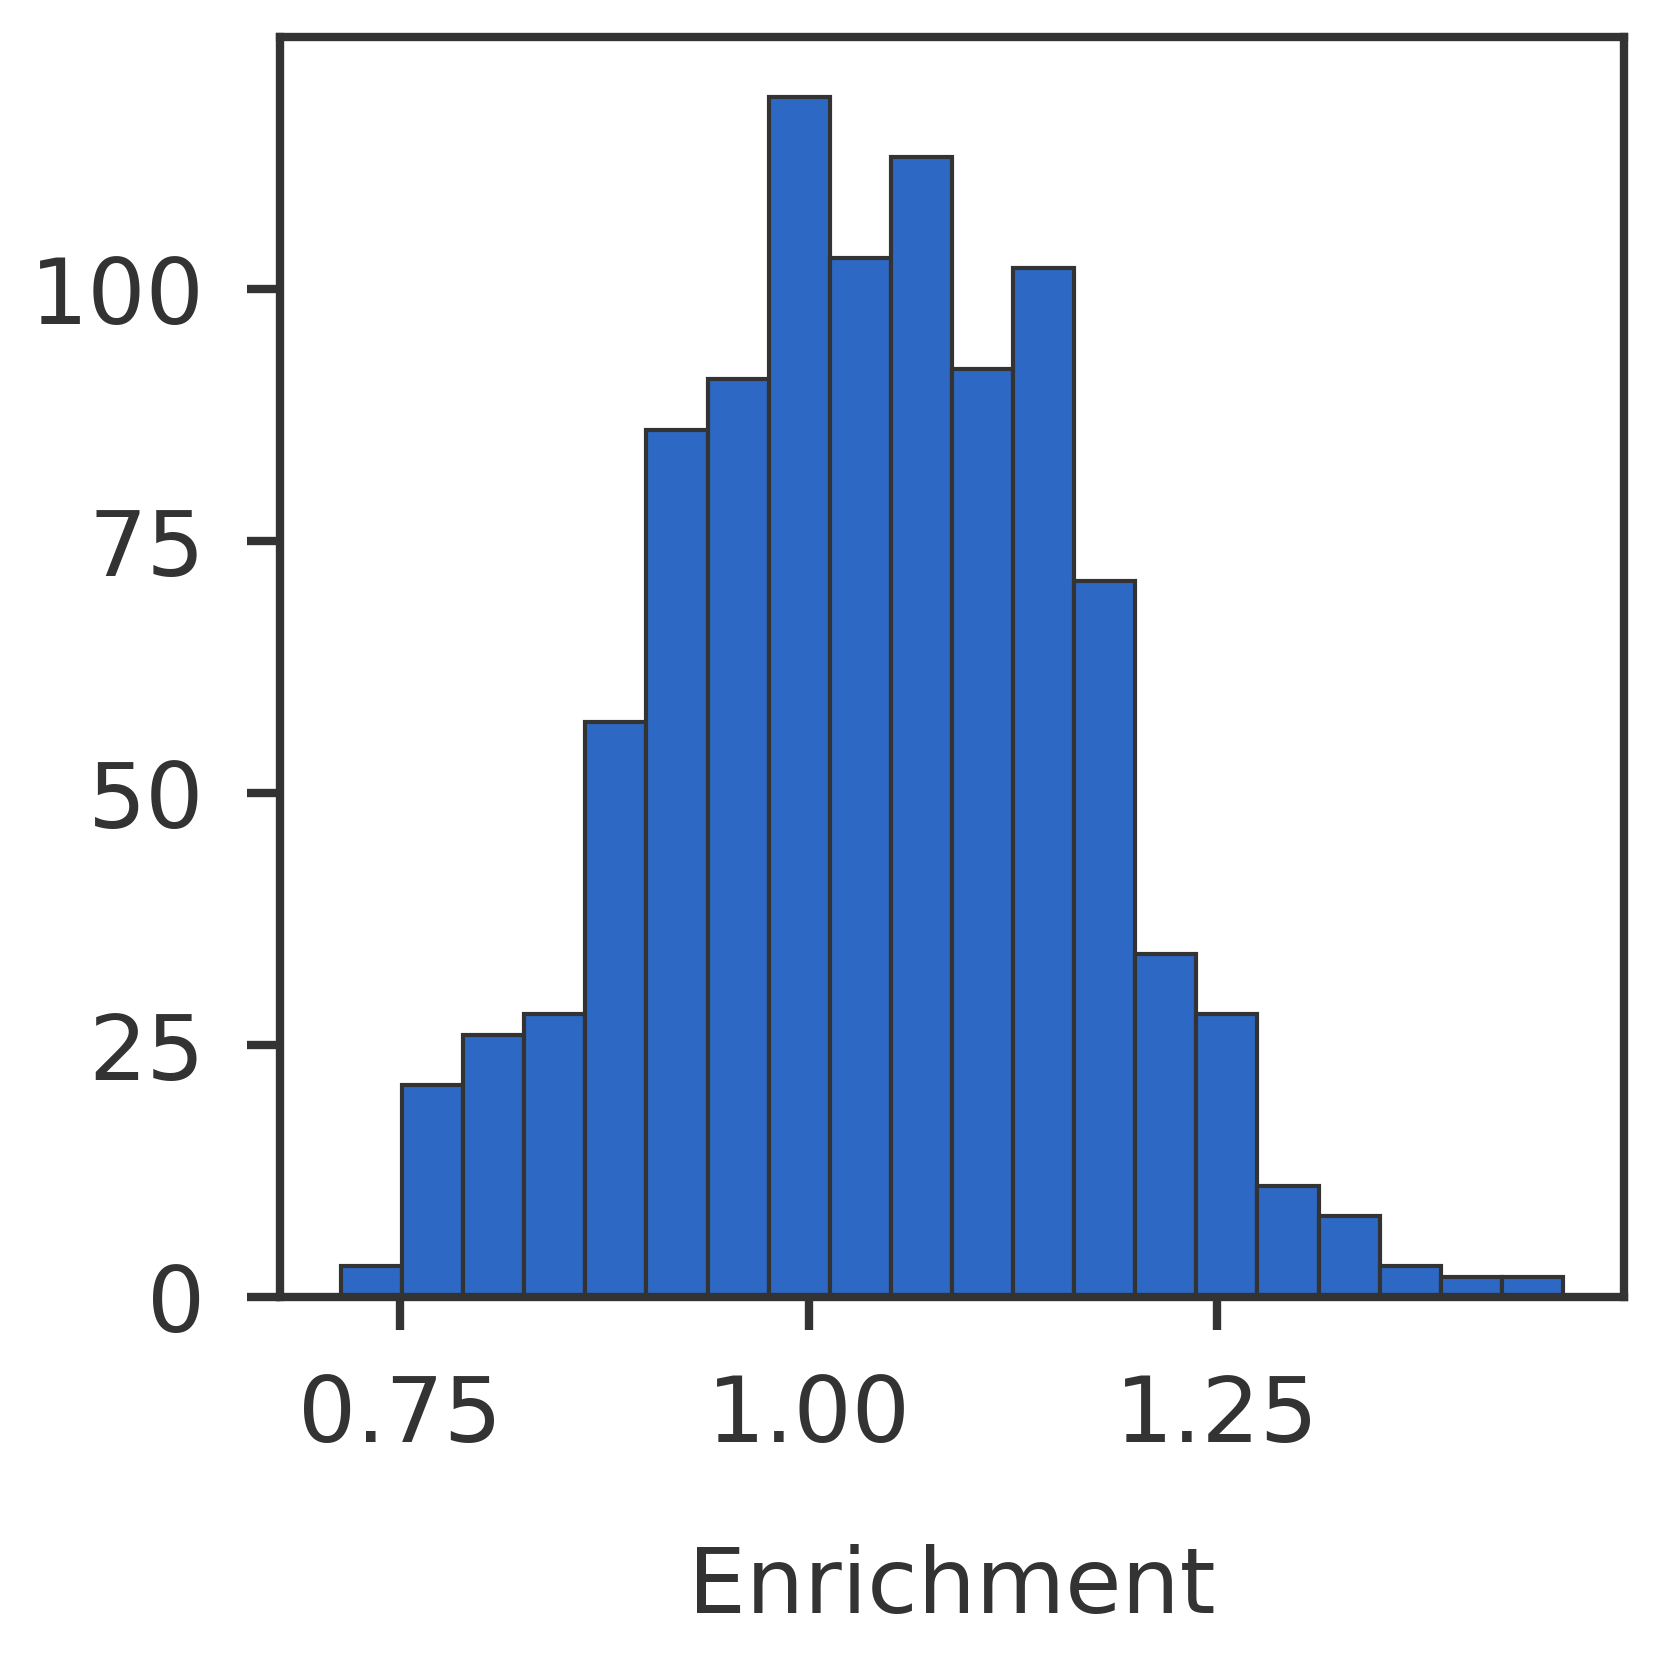

In [56]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

ax1.hist(enrichment_rand)
ax1.set_xlabel('Enrichment')
plt.tight_layout()
plt.show()

In [57]:
tshorts, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
for tshort, tfull in zip(tshorts, tfulls):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]

In [58]:
transeqtls = dict()

for tissue in tshorts:
    filename = os.path.join(resdir, tissue, rrfile)
    if os.path.isfile(filename):
        transeqtls[tissue] = read_tejaas_results.transeqtls(filename)
        print(f'{tissue}: {len(transeqtls[tissue])} trans-eQTLs')
    else:
        print(f'{tissue}: Result file not found.')

SNPs with zero p-value: 23
as: 1646 trans-eQTLs
av: 514 trans-eQTLs
SNPs with zero p-value: 126
aa: 3999 trans-eQTLs
at: 1068 trans-eQTLs
br: 812 trans-eQTLs
SNPs with zero p-value: 9
colt: 2310 trans-eQTLs
SNPs with zero p-value: 6
esom: 90 trans-eQTLs
esomu: 33 trans-eQTLs
haa: 0 trans-eQTLs
hlv: 336 trans-eQTLs
SNPs with zero p-value: 6
lu: 1076 trans-eQTLs
SNPs with zero p-value: 34
ms: 3668 trans-eQTLs
SNPs with zero p-value: 4
nt: 2117 trans-eQTLs
SNPs with zero p-value: 11
snse: 1449 trans-eQTLs
SNPs with zero p-value: 13
sse: 376 trans-eQTLs
SNPs with zero p-value: 44
thy: 2971 trans-eQTLs
wb: 0 trans-eQTLs
SNPs with zero p-value: 16
ag: 281 trans-eQTLs
SNPs with zero p-value: 48
ac: 3396 trans-eQTLs
bam: Result file not found.
ban: Result file not found.
SNPs with zero p-value: 37
bca: 56 trans-eQTLs
SNPs with zero p-value: 42
bceh: 475 trans-eQTLs
SNPs with zero p-value: 25
bce: 57 trans-eQTLs
SNPs with zero p-value: 32
bco: 160 trans-eQTLs
SNPs with zero p-value: 45
bfr: 90 

In [59]:
eqtlgen_resfile = '/scratch/sbanerj/from_franco/EQTLgen/eqtlgen_signif_SNPs_uniq_rsid_chr_pos.txt'

if not 'eqtlgen' in tshorts:
    tshorts += ['eqtlgen']
    tfulls += ['EQTLGen']
    transeqtls['eqtlgen'] = list()

    with open(eqtlgen_resfile, 'r') as infile:
        for line in infile:
            linesplit = line.strip().split()
            chrm = int(linesplit[1].strip())
            pos = int(linesplit[2].strip())
            varid = f'chr{chrm}_{pos}_eqtlgen'
            thisres = EqtlInfo(chrom = chrm, varid = varid, bp_pos = pos, pval = 5e-8, log10pval = -np.log10(5e-8))
            transeqtls['eqtlgen'].append(thisres)

    tissue_names['eqtlgen'] = 'EQTLGen'
    tissue_colors['eqtlgen'] = 'gray'

In [60]:
mindist = dict()

tfstarts = dict()
tfends = dict()
for chrm in chrmlist:
    tfstarts[chrm] = [x.start for x in tflist if x.chrom == chrm]
    tfends[chrm] = [x.end for x in tflist if x.chrom == chrm]    

for tissue, teqtllist in transeqtls.items():
    mindist[tissue] = list()
    for teqtl in teqtllist:
        chrm = teqtl.chrom
        spos = teqtl.bp_pos
        xmin = find_minimum_distance(spos, tfstarts[chrm], tfends[chrm])
        mindist[tissue].append(xmin / 1e6)

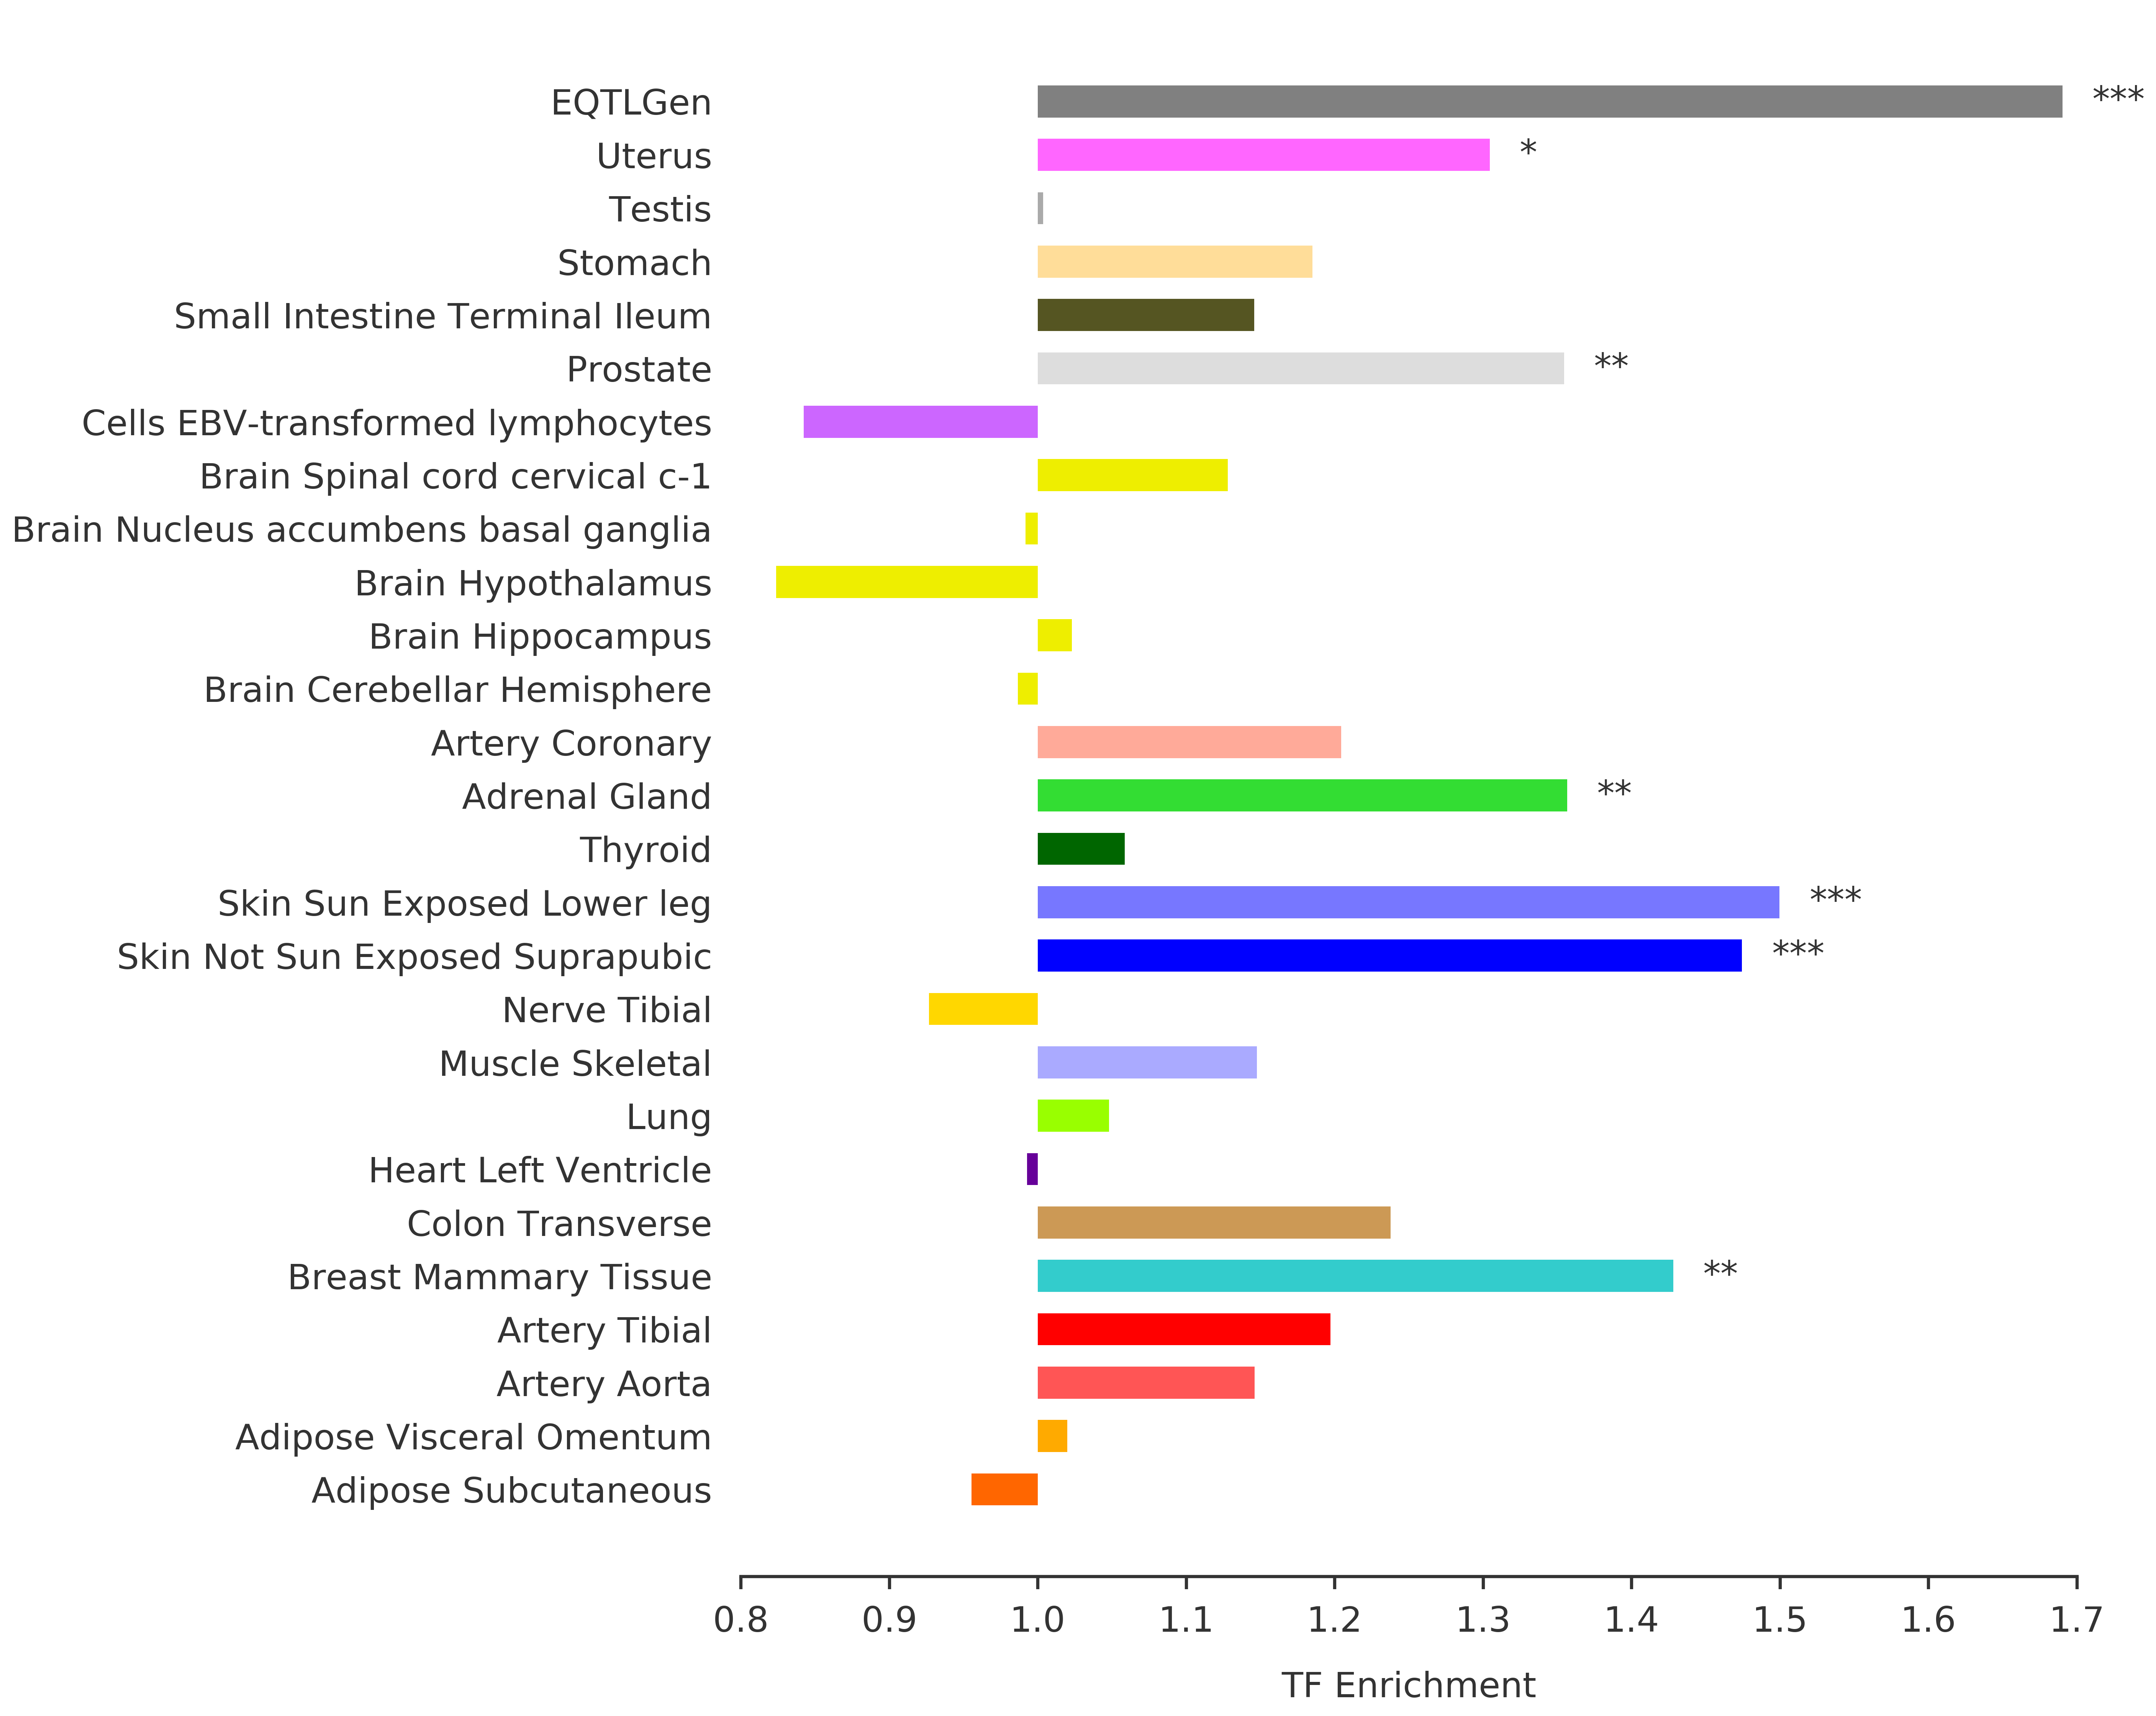

In [63]:
objects = list()
performance = list()
significance = list()
bar_colors = list()

plot_tissues = [t for t, _ in mindist.items()]

for tshort in tshorts:
    if tshort in plot_tissues:
        nteqtl = len(transeqtls[tshort])
        if nteqtl >= 200:
        #if nteqtl < 200:            
            if nteqtl == 0:
                objects.append(tissue_names[tshort])
                performance.append(0)
                significance.append('')
            else:            
                tf_frac_tissue = len([x for x in mindist[tshort] if abs(x) <= cis_window]) / nteqtl
                tf_enrichment = tf_frac_tissue / tf_frac_rand
                tf_enrichment_pval = (np.sum(enrichment_rand >= tf_enrichment) + 1) / (enrichment_rand.shape[0] + 1)

                objects.append(tissue_names[tshort])
                performance.append(tf_enrichment - 1.0)
                if tf_enrichment_pval <= 0.001:
                    significance.append('***')
                elif tf_enrichment_pval <= 0.01:
                    significance.append('**')
                elif tf_enrichment_pval <= 0.05:
                    significance.append('*')
                else:
                    significance.append('')
            bar_colors.append(tissue_colors[tshort])

        

fig = plt.figure(figsize = (15, 18))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.6)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('TF Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "../plots/tf_enrichment_100kb_gtsampling.png"
plt.savefig(outfile, bbox_inches='tight')
plt.show()